11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


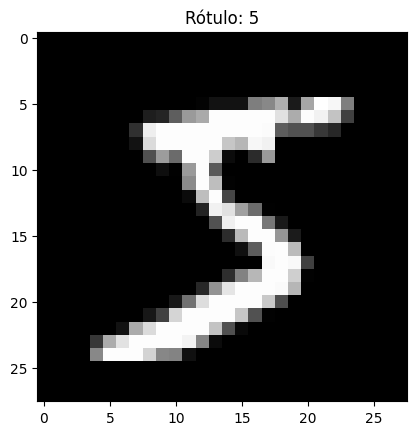

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_bin = (x_train > 127).astype(int)
x_test_bin = (x_test > 127).astype(int)
x_train_bin = x_train_bin.reshape((-1, 784))
x_test_bin = x_test_bin.reshape((-1, 784))

plt.imshow(x_train[0], cmap='gray')
plt.title(f'Rótulo: {y_train[0]}')
plt.show()

In [24]:
import random
from collections import defaultdict

class Discriminator:
    def __init__(self, input_size, address_size, mapping=None):
        self.input_size = input_size
        self.address_size = address_size
        self.num_rams = input_size // address_size

        if mapping is None:
            positions = list(range(input_size))
            random.shuffle(positions)
            self.mapping = [
                positions[i * address_size:(i + 1) * address_size]
                for i in range(self.num_rams)
            ]
        else:
            self.mapping = mapping

        self.rams = [defaultdict(int) for _ in range(self.num_rams)]

    def train(self, input_bits):
        for i, ram in enumerate(self.rams):
            address = ''.join(str(input_bits[j]) for j in self.mapping[i])
            ram[address] += 1

    def predict(self, input_bits):
        score = 0
        for i, ram in enumerate(self.rams):
            address = ''.join(str(input_bits[j]) for j in self.mapping[i])
            if ram[address] > 0:
                score += 1
        return score

In [25]:
import time

input_size = 784
address_size = 46
classes = list(range(10))

positions = list(range(input_size))
random.shuffle(positions)
shared_mapping = [
    positions[i * address_size:(i + 1) * address_size]
    for i in range(input_size // address_size)
]

discriminators = {
    label: Discriminator(input_size, address_size, mapping=shared_mapping)
    for label in classes
}

start_train = time.time()

for i in range(len(x_train_bin)):
    sample = x_train_bin[i]
    label = y_train[i]
    discriminators[label].train(sample)

end_train = time.time()
print("Treinamento completo.")
print("Tempo de treinamento: {:.4f} segundos".format(end_train - start_train))

Treinamento completo.
Tempo de treinamento: 15.6831 segundos


In [28]:
def predict_label(sample):
    scores = {
        label: discrim.predict(sample)
        for label, discrim in discriminators.items()
    }

    max_score = max(scores.values())
    for bleaching_level in reversed(range(max_score + 1)):
        candidatos = [label for label, score in scores.items() if score >= bleaching_level]
        if len(candidatos) == 1:
            return candidatos[0]
    return candidatos[0]

start_test = time.time()

correct = 0
for i in range(len(x_test_bin)):
    sample = x_test_bin[i]
    true_label = y_test[i]
    predicted = predict_label(sample)
    if predicted == true_label:
        correct += 1

end_test = time.time()

accuracy = 100 * correct / len(x_test_bin)

print(f"Acurácia no conjunto de teste: {accuracy:.2f}%")
print(f"Tempo de teste: {end_test - start_test:.4f} segundos")

Acurácia no conjunto de teste: 90.58%
Tempo de teste: 26.3052 segundos


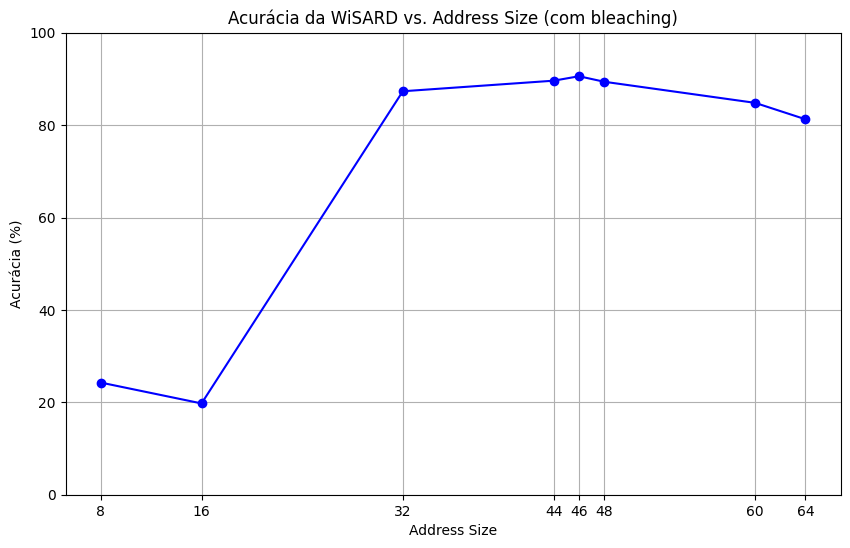

In [29]:
import matplotlib.pyplot as plt

address_sizes = [8, 16, 32, 44, 46, 48, 60, 64]
accuracies = [24.27, 19.76, 87.33, 89.62, 90.58, 89.39, 84.82, 81.27]

plt.figure(figsize=(10, 6))
plt.plot(address_sizes, accuracies, marker='o', linestyle='-', color='blue')
plt.title("Acurácia da WiSARD vs. Address Size (com bleaching)")
plt.xlabel("Address Size")
plt.ylabel("Acurácia (%)")
plt.grid(True)
plt.xticks(address_sizes)
plt.ylim(0, 100)
plt.show()

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3
start_train = time.time()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Época {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
end_train = time.time()
print("Tempo de treinamento: {:.2f} segundos".format(end_train - start_train))

model.eval()
correct = 0
total = 0
start_test = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
end_test = time.time()
accuracy = 100 * correct / total

print("Tempo de teste: {:.2f} segundos".format(end_test - start_test))
print(f"Acurácia: {accuracy:.2f}%")

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.37MB/s]


Época 1/3, Loss: 0.1773
Época 2/3, Loss: 0.0491
Época 3/3, Loss: 0.0362
Tempo de treinamento: 220.66 segundos
Tempo de teste: 6.97 segundos
Acurácia: 98.91%


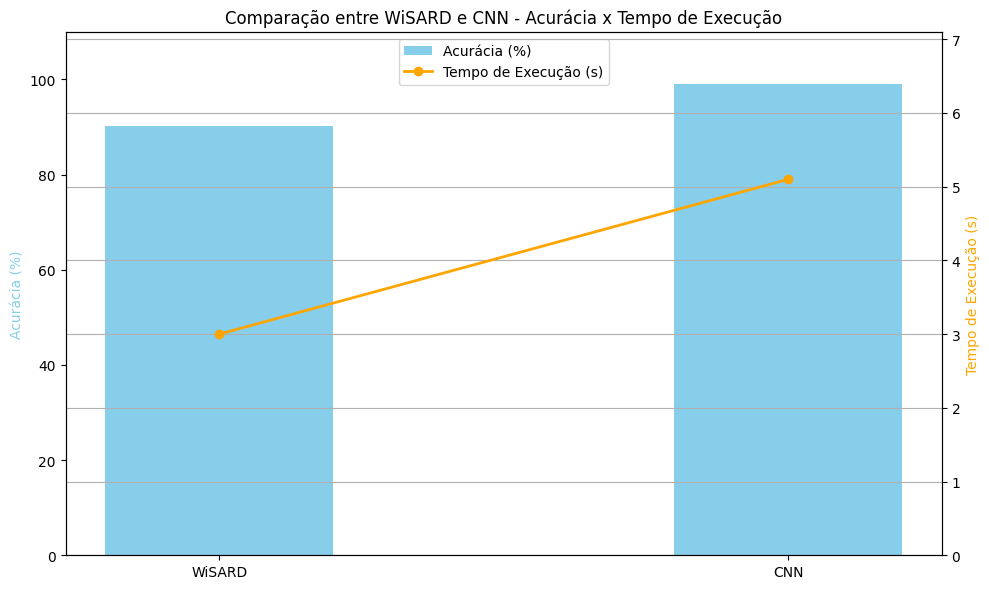

In [30]:
import matplotlib.pyplot as plt

modelos = ['WiSARD', 'CNN']
acuracias = [90.15, 99.01]
tempos = [3.00, 5.10]

fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(modelos))

ax1.bar(x, acuracias, width=0.4, label='Acurácia (%)', color='skyblue', align='center')
ax1.set_ylabel('Acurácia (%)', color='skyblue')
ax1.set_ylim([0, 110])
ax1.set_xticks(x)
ax1.set_xticklabels(modelos)
ax1.set_title('Comparação entre WiSARD e CNN - Acurácia x Tempo de Execução')

ax2 = ax1.twinx()
ax2.plot(x, tempos, label='Tempo de Execução (s)', color='orange', marker='o', linewidth=2)
ax2.set_ylabel('Tempo de Execução (s)', color='orange')
ax2.set_ylim([0, max(tempos) + 2])
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.grid(True)
plt.tight_layout()
plt.show()